### Import Libraries

In [1]:
#Data
import pandas as pd
import numpy as np

#Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib import cm
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D #3d Plotting

#Geo-Visualisation
#import geopandas as gpd
#from shapely.geometry import Point, Polygon
#import contextily as ctx

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.cluster import MiniBatchKMeans, KMeans

### Helper Functions

In [2]:
# Source: 
from math import radians, cos, sin, asin, sqrt 
def calculate_distance(lon1, lat1, lon2, lat2): 
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371 
    km = 6371* c 
    return km

In [3]:
#Kann raus oder?
def next_cluster(lng,lat,cluster_df):
    smallest_value = 9999999999999999 #nicht schön aber sollte funktionieren.
    for index, row in cluster_df.iterrows():
        cluster_lng = row["lng"]
        cluster_lat = row["lat"]
        distance = calculate_distance(lng,lat,cluster_lng,cluster_lat)
        if distance < smallest_value:
            smallest_value = distance
            closest_cluster = [cluster_lng,cluster_lat]
    return closest_cluster

In [4]:
# Source: 
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

In [5]:
# Source: self-written
def moving_average(array,n):
    target = []
    rng = n / 2 - 0.5
    rng = int(rng)
    i = 0
    while i < len(array):
        value = 0
        if (i >= rng-1) & (i< len(array)-rng):
            value = sum(array[i-rng:i+rng+1])/n
        target.append(value)
        i = i + 1
    i = 0
    while i < rng:
        target[i] = target[rng]
        target[-i-1] = target[-rng-1]
        i = i + 1
        
    return target

________________________

# 1. Data Cleaning

## 1.1 Importing raw data
We import the given dataset. 

We also import self-gathered data:
- Daily information on whether the day was a national or regional holiday or whether there were school vacations
- Geo-coordinates for city centers of both cities
- SHP files for the cities including city districts

In [6]:
df_b = pd.read_csv("./dataset/bochum.csv")
df_l = pd.read_csv("./dataset/leipzig.csv")

In [7]:
#Self-gathered datasets that gives information about the relevant days
date_info_l = pd.read_csv("./resources/date-info/leipzig-dateinfo.csv",sep=";")
date_info_l["date"] = pd.to_datetime(date_info_l["date"],format="%d.%m.%Y").dt.date
date_info_l.index = date_info_l["date"]
date_info_l = date_info_l.drop(columns=["date"])

date_info_b = pd.read_csv("./resources/date-info/leipzig-dateinfo.csv",sep=";")
date_info_b["date"] = pd.to_datetime(date_info_b["date"],format="%d.%m.%Y").dt.date
date_info_b.index = date_info_b["date"]
date_info_b = date_info_b.drop(columns=["date"])

In [8]:
leipzig = {"lng": 12.3741468,"lat": 51.340744}
bochum = {"lng": 7.2164417,"lat": 51.4816637}

In [9]:
leipzig_map = gpd.read_file("./resources/leipzig/ot.shp").to_crs(epsg=4326) #original file is in a different system
bochum_map = gpd.read_file("./resources/bochum/Stadtbezirke.shp").to_crs(epsg=4326).rename(columns={"Stadtbezir":"Name"})

NameError: name 'gpd' is not defined

## 1.2 Looking for null values
We look for holes in the data. Note that, as data event-based and not continuous, we do not discover missing "events" (e.g. if there are no records for certain days).

In [ ]:
print("Total number of null values:",
      (sum(df_l.isnull().sum())+sum(df_l.isnull().sum())))

## 1.3 Correcting Data Types

In [10]:
def correct_data_types(Nextbike):
    #Converting Trip Length to timedelta
    Nextbike['trip_duration'] = pd.to_timedelta(Nextbike['trip_duration'])

    #Converting start-time to datetime
    Nextbike['timestamp'] = pd.to_datetime(Nextbike['day'] + ' ' +  Nextbike['time'])
    Nextbike.drop(columns=['day','time'], inplace = True)

    #round coordinates to filter out gps unpreciseness
    cols = ["orig_lat","orig_lng","dest_lat","dest_lng"]
    Nextbike[cols] = Nextbike[cols].round(3)
    
    return Nextbike

df_l = correct_data_types(df_l)
df_b = correct_data_types(df_b)

## 1.4 Adding columns for analysis
We then proceed to calculate some useful columns that will help us analyse the dataset. While this might produce some columns that are not frequently used, we benefit from having all beneficial information ready for use.

To attempt to approximate the resulting revenue, we stick to the only pricing strategy that can be applied to the data that we have, which is 1€ per 30 minutes. Note that Nextbike offers a lot of different pricing strategies, including flat rates and free minutes for students. We do not have enough information to include these in our calculation - so the Revenue metric is very likely to be misrepresentative and has to be taken with a grain of salt.

In [11]:
def add_columns_analysis(Nextbike,date_info):
    Nextbike['timestamp_rounded'] = Nextbike['timestamp'].dt.floor('H')

    Nextbike["date"] = Nextbike.timestamp.dt.date
    Nextbike['weekday'] = Nextbike['timestamp_rounded'].dt.weekday
    Nextbike['week'] = Nextbike['timestamp_rounded'].dt.isocalendar().week
    
    Nextbike["trip_duration_minutes"] = Nextbike["trip_duration"].dt.total_seconds()/60

    Nextbike['Time'] = Nextbike['timestamp_rounded'].dt.time
    Nextbike["Time"] = Nextbike["Time"].astype(str).str[:2].astype(int)

    Nextbike['Time_float'] = Nextbike['timestamp'].dt.time
    Nextbike['Time_float'] = Nextbike['Time_float'].astype(str).str[3:5].astype(float)/60 + Nextbike["Time"]
    
    #take trip duration in minutes, calculate 1€ per 30 minutes of usage
    Nextbike["revenue"] = np.ceil((Nextbike.trip_duration.dt.total_seconds()/60) /30)
      
        
    Nextbike=pd.merge(Nextbike,date_info,left_on="date",right_index=True)
    Nextbike["free"] = ((Nextbike["day_classifier"]=="weekend") | (Nextbike["holiday"]=="1"))
    
    return Nextbike


df_l = add_columns_analysis(df_l,date_info_l)
df_b = add_columns_analysis(df_b,date_info_b)

In [12]:
def calc_traveled_distance(df):
    distances = []
    for index, row in df.iterrows():
        distances.append(calculate_distance(row["orig_lng"], 
                                            row["orig_lat"],
                                            row["dest_lng"], 
                                            row["dest_lat"]))
    return distances

df_l["distance_traveled"]=calc_traveled_distance(df_l)
df_b["distance_traveled"] = calc_traveled_distance(df_b)
df_l

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,date,...,week,trip_duration_minutes,Time,Time_float,revenue,day_classifier,vacations,holiday,free,distance_traveled
0,10900,leipzig,0 days 00:12:00,51.330,12.342,51.330,12.342,2019-04-16 11:17:00,2019-04-16 11:00:00,2019-04-16,...,16,12.0,11,11.283333,1.0,weekday,0,0,False,0.000000
1,10900,leipzig,0 days 00:08:00,51.330,12.342,51.330,12.342,2019-04-16 11:35:00,2019-04-16 11:00:00,2019-04-16,...,16,8.0,11,11.583333,1.0,weekday,0,0,False,0.000000
2,10900,leipzig,0 days 00:40:00,51.330,12.342,51.330,12.342,2019-04-16 11:53:00,2019-04-16 11:00:00,2019-04-16,...,16,40.0,11,11.883333,2.0,weekday,0,0,False,0.000000
3,10900,leipzig,0 days 00:03:00,51.330,12.342,51.330,12.342,2019-04-16 14:35:00,2019-04-16 14:00:00,2019-04-16,...,16,3.0,14,14.583333,1.0,weekday,0,0,False,0.000000
2788,20204,leipzig,0 days 00:13:00,51.333,12.404,51.339,12.382,2019-04-16 05:52:00,2019-04-16 05:00:00,2019-04-16,...,16,13.0,5,5.866667,1.0,weekday,0,0,False,1.667600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171614,39065,leipzig,0 days 00:38:00,51.326,12.375,51.331,12.374,2019-03-27 15:06:00,2019-03-27 15:00:00,2019-03-27,...,13,38.0,15,15.100000,2.0,weekday,0,0,False,0.560299
171615,39065,leipzig,0 days 00:10:00,51.331,12.374,51.335,12.391,2019-03-27 16:28:00,2019-03-27 16:00:00,2019-03-27,...,13,10.0,16,16.466667,1.0,weekday,0,0,False,1.262030
171616,39065,leipzig,0 days 00:07:00,51.335,12.391,51.332,12.406,2019-03-27 17:09:00,2019-03-27 17:00:00,2019-03-27,...,13,7.0,17,17.150000,1.0,weekday,0,0,False,1.094186
171617,39065,leipzig,0 days 00:09:00,51.331,12.406,51.319,12.401,2019-03-27 18:00:00,2019-03-27 18:00:00,2019-03-27,...,13,9.0,18,18.000000,1.0,weekday,0,0,False,1.378829


## 1.5 Creating an array with all dates
This is just a simple array that contains all dates from the range of our data. It will help us in our analysis on some occasions.

In [13]:
start_date = df_l.date.min()
end_date = df_l.date.max()
delta = pd.to_timedelta("1d")
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
    
dates_df = pd.DataFrame(index=dates)

## 1.6 Filtering out unrealistic rides
This step is aimed at filtering out rides that have start or end locations far out from the city and thus is likely not a regular ride within the valid area. We start by calculating the distances to the city centre for origin and destination. We then filter out rides that are way outside of the distribution of distance.

Text(0.5, 1.0, 'Bochum')

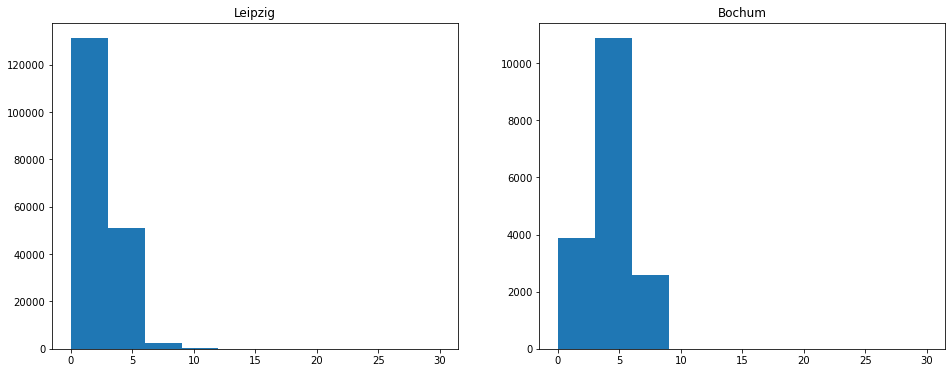

In [14]:
def add_distances_center(df,city):
    start_distance_center = []
    end_distance_center = []
    max_distance_center = []

    for index, row in df.iterrows():
        start = calculate_distance(lon1 = row["orig_lng"],
                               lat1 = row["orig_lat"],
                               lon2 = city["lng"],
                               lat2 = city["lat"])
        end = calculate_distance(lon1 = row["dest_lng"], 
                                lat1 = row["dest_lat"],
                                lon2 = city["lng"],
                                lat2 = city["lat"])
        if start > end:
            max = start
        else:
            max = end
        start_distance_center.append(start)
        end_distance_center.append(end)
        max_distance_center.append(max)

    df["start_distance_center"] = start_distance_center
    df["end_distance_center"] = end_distance_center
    df["max_distance_center"] = max_distance_center

    #df["max_distance_center"] = df["max_distance_center"].round()

    distances = df.groupby("max_distance_center").agg(
    count = ("b_number","count"))

    
add_distances_center(df_l,leipzig)
add_distances_center(df_b,bochum)

# Output
Fig_1, axes = plt.subplots(1, 2, figsize=(16, 6))

x = df_l["max_distance_center"]
axes[0].hist(x,range=(0,30))
axes[0].set_title('Leipzig')

x = df_b["max_distance_center"]
axes[1].hist(x,range=(0,30))
axes[1].set_title('Bochum')

In [15]:
df_b

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,date,...,Time_float,revenue,day_classifier,vacations,holiday,free,distance_traveled,start_distance_center,end_distance_center,max_distance_center
0,683,bochum,0 days 00:10:00,51.490,7.233,51.480,7.222,2019-02-08 12:06:00,2019-02-08 12:00:00,2019-02-08,...,12.100000,1.0,weekday,0,0,False,1.347806,1.474373,0.427058,1.474373
153,4422,bochum,0 days 00:12:00,51.468,7.215,51.480,7.222,2019-02-08 10:53:00,2019-02-08 10:00:00,2019-02-08,...,10.883333,1.0,weekday,0,0,False,1.419687,1.522612,0.427058,1.522612
154,4422,bochum,0 days 00:06:00,51.480,7.222,51.482,7.215,2019-02-08 15:53:00,2019-02-08 15:00:00,2019-02-08,...,15.883333,1.0,weekday,0,0,False,0.533325,0.427058,0.106609,0.427058
155,4422,bochum,0 days 00:13:00,51.482,7.215,51.473,7.217,2019-02-08 21:14:00,2019-02-08 21:00:00,2019-02-08,...,21.233333,1.0,weekday,0,0,False,1.010294,0.106609,0.964135,0.964135
297,7020,bochum,0 days 00:08:00,51.481,7.133,51.474,7.139,2019-02-08 15:11:00,2019-02-08 15:00:00,2019-02-08,...,15.183333,1.0,weekday,0,0,False,0.882335,5.778710,5.430437,5.778710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14445,53362,bochum,0 days 00:05:00,51.457,7.271,51.452,7.273,2019-03-03 15:57:00,2019-03-03 15:00:00,2019-03-03,...,15.950000,1.0,weekend,0,0,True,0.572985,4.669338,5.121451,5.121451
15456,53567,bochum,0 days 00:08:00,51.478,7.207,51.480,7.222,2019-03-03 02:50:00,2019-03-03 02:00:00,2019-03-03,...,2.833333,1.0,weekend,0,0,True,1.062324,0.770376,0.427058,0.770376
15877,53608,bochum,0 days 00:08:00,51.473,7.241,51.480,7.222,2019-03-03 16:10:00,2019-03-03 16:00:00,2019-03-03,...,16.166667,1.0,weekend,0,0,True,1.528842,1.954667,0.427058,1.954667
16861,53863,bochum,0 days 00:09:00,51.453,7.246,51.448,7.234,2019-03-03 00:23:00,2019-03-03 00:00:00,2019-03-03,...,0.383333,1.0,weekend,0,0,True,1.000289,3.788257,3.935893,3.935893


In [16]:
df_b.sort_values(by="max_distance_center",ascending=False)

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,date,...,Time_float,revenue,day_classifier,vacations,holiday,free,distance_traveled,start_distance_center,end_distance_center,max_distance_center
1460,21314,bochum,0 days 00:03:00,50.931,6.917,50.931,6.917,2019-04-26 13:50:00,2019-04-26 13:00:00,2019-04-26,...,13.833333,1.0,weekday,1,0,False,0.000000,64.686855,64.686855,64.686855
11008,52299,bochum,0 days 01:21:00,51.454,7.250,51.433,7.126,2019-03-29 15:49:00,2019-03-29 15:00:00,2019-03-29,...,15.816667,3.0,weekday,0,0,False,8.905563,3.855612,8.279300,8.279300
14254,53324,bochum,0 days 00:52:00,51.433,7.126,51.427,7.143,2019-05-17 14:16:00,2019-05-17 14:00:00,2019-05-17,...,14.266667,2.0,weekday,0,0,False,1.354292,8.279300,7.927265,8.279300
550,7037,bochum,0 days 00:14:00,51.433,7.126,51.427,7.143,2019-06-21 13:24:00,2019-06-21 13:00:00,2019-06-21,...,13.400000,1.0,weekday,0,0,False,1.354292,8.279300,7.927265,8.279300
9376,51449,bochum,0 days 00:13:00,51.433,7.126,51.427,7.143,2019-06-06 13:56:00,2019-06-06 13:00:00,2019-06-06,...,13.933333,1.0,weekday,0,0,False,1.354292,8.279300,7.927265,8.279300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,50343,bochum,0 days 00:19:00,51.483,7.215,51.482,7.215,2019-06-19 10:06:00,2019-06-19 10:00:00,2019-06-19,...,10.100000,1.0,weekday,0,0,False,0.111195,0.179013,0.106609,0.179013
16068,53639,bochum,0 days 00:41:00,51.482,7.215,51.483,7.215,2019-04-23 20:04:00,2019-04-23 20:00:00,2019-04-23,...,20.066667,2.0,weekday,1,0,False,0.111195,0.106609,0.179013,0.179013
8448,51195,bochum,0 days 00:07:00,51.483,7.215,51.482,7.215,2019-02-18 12:50:00,2019-02-18 12:00:00,2019-02-18,...,12.833333,1.0,weekday,1,0,False,0.111195,0.179013,0.106609,0.179013
17165,53947,bochum,0 days 00:07:00,51.483,7.215,51.482,7.215,2019-05-07 15:59:00,2019-05-07 15:00:00,2019-05-07,...,15.983333,1.0,weekday,0,0,False,0.111195,0.179013,0.106609,0.179013


In [17]:
df_l = df_l[df_l["max_distance_center"]<=15]
df_b = df_b[df_b["max_distance_center"]<=10]

## 1.7 Calculate Size of the Fleet
As in our opinion, the total number of available bikes plays a major role in KPIs (e.g. amount of rides per available bikes), but is also a relevant feature for predicting bike demand (we suspect more available bikes per km2 --> more attractive to rent a bike), we feel it is vital to know how the size of the fleet in the respective city changes over time.

Unfortunately, this data is not available in our dataset and thus has to be approximated through logics.

Our idea is to first get a feel about how much time (maximally) lies between rides with one specific bike. If we, for example, know that bikes never go over 7 days of not being used, we can count the number of unique bike IDs that were ridden at least once in the last 7 days to approximate the fleet size for a given date.

Text(0.5, 1.0, 'Bochum')

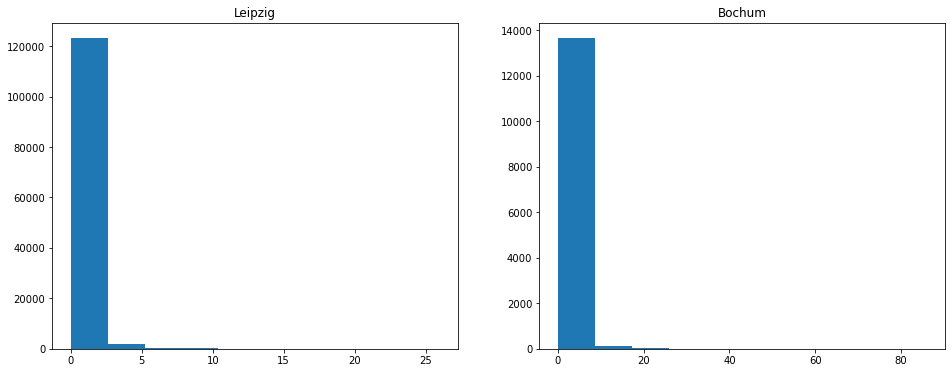

In [18]:
def stood_time(df):
    
    dfx = df.copy()[["b_number","timestamp","trip_duration","orig_lat","orig_lng","dest_lat","dest_lng"]]
    dfx["timestamp_end"] = dfx["timestamp"] + dfx["trip_duration"]
    
    events = []
    
    for number in dfx["b_number"].unique():
        dfi = dfx[dfx["b_number"]==number].sort_values(by="timestamp")
        i = 0
        for index,row in dfi.iterrows():
            i = i + 1
            if i > 1:
                status = "moved"
                if [row["orig_lat"],row["orig_lng"]] == last_dest:
                    status = "stood"

                d = {
                    "b_number": number,
                    "from": last_timestamp,
                    "to": row["timestamp"],
                    "status": status
                }
                events.append(d)
            last_timestamp = row["timestamp_end"]
            last_dest = [row["dest_lat"],row["dest_lng"]]

    events = pd.DataFrame(events)
    events["length"] = events["to"] - events["from"]
    events["length_days"] = events["length"].dt.total_seconds() / (60* 60* 24)
    events["length_days"] = events["length_days"].round()
    
    return events[events["status"]=="stood"]
    

stood_l = stood_time(df_l)
stood_b = stood_time(df_b)

# Output
Fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = stood_l["length_days"]
axes[0].hist(x)
axes[0].set_title('Leipzig')

x = stood_b["length_days"]
axes[1].hist(x)
axes[1].set_title('Bochum')

We see that for Leipzig, most time deltas between rides seem to be from 0 to 3 days, with some ranging up to 10. Bochum shows a similar distribution, although there is a visible amount up to arount 20. We choose our calculation parameter accordingly.

Note that this is a balancing act: If we choose this number to high, we will include bikes that are not really in use anymore. If we choose it too small, we might not include bikes that are still active but were simply not used for a longer amount of time.

In [19]:
def fleet_size(df,factor):
    
    fleet_size = pd.DataFrame([], index = dates, columns = ["fleet_size"]) 

    search_array = []
    values = []
    for index, row in fleet_size.iterrows():
        search_array.append(index)
        if len(search_array) > factor:
            search_array.pop(0)
        values.append(df[df["date"].isin(search_array[:])].b_number.nunique())
        
    i = 0
    
    #Erklärung hierfür
    correction = values[factor-1]
    while i < factor-1:
        values[i] = correction
        i = i + 1
    fleet_size["fleet_size"] = values
    
    return fleet_size

fleet_size_l = fleet_size(df_l,10)
fleet_size_b = fleet_size(df_b,20)

## 1.8 Creating per-day DataFrame
This is as multi-purpose DataFrame that aggregates our rides to Dates. It contains all information that can be expressed on a date level.

In [20]:
def df_by_date(df,fleet_size):
    df_by_date = df.groupby("date").agg(
        week = ("week","min"),
        weekday = ("weekday","min"),
        daily_revenue=('revenue', "sum"),
        daily_trips=("b_number","count"),
        free = ("free","min"),
        daily_avg_length = ("trip_duration_minutes","mean"),
        daily_used_bikes=('b_number', pd.Series.nunique))

    df_by_date_merged = df_by_date.join(fleet_size) #this does not include the missing days
    df_by_date_merged["daily_usage"] = df_by_date_merged["daily_used_bikes"] / df_by_date_merged["fleet_size"]

    
    return df_by_date_merged


df_date_l = df_by_date(df_l,fleet_size_l)
df_date_b = df_by_date(df_b,fleet_size_b)

In [21]:
def add_trips_week(df):
    df_week = df.groupby("week").agg(weekly_trips=("daily_trips","sum"))
    return pd.merge(df,df_week,left_on="week",right_index=True,how="left")

In [22]:
df_date_l = add_trips_week(df_date_l)
df_date_l["weekly_relative_trips"] = df_date_l["daily_trips"] / df_date_l["weekly_trips"]
df_date_b = add_trips_week(df_date_b)
df_date_b["weekly_relative_trips"] = df_date_b["daily_trips"] / df_date_b["weekly_trips"]

## Creating per-hour DataFrame
This DataFrame is the core of the project as most of the analyses rely on hourly data. It contains all useful hour-level data, and it contains all day-level data such as fleet size, day classifiers etc. While daily data is now stored reduntantly both in the per-day and the per-hour DataFrame, it makes it most usable for analysis. Because our number of features and instances are of manageable size, this is not a problem.

In [23]:
def df_by_hour(df,df_date):

    df_by_hour = df.groupby("timestamp_rounded").agg(
        revenue=('revenue', "sum"),
        trips=("b_number","count"),
        date=("date","min"),
        time = ("Time","min"),
        avg_length = ("trip_duration_minutes","mean"),
        weekday=("weekday","min"),
        used_bikes=('b_number', pd.Series.nunique))


    df_by_hour_merged = pd.merge(df_by_hour, df_date, right_index=True, left_on='date')


    df_by_hour_merged["usage"] = df_by_hour_merged["used_bikes"] / df_by_hour_merged["fleet_size"]
    df_by_hour_merged["relative_trips"] = df_by_hour_merged["trips"] / df_by_hour_merged["daily_trips"]
    
    return df_by_hour_merged


df_hour_l = df_by_hour(df_l, df_date_l)
df_hour_b = df_by_hour(df_b, df_date_b)

___________________________________

# 2. Descriptive Analytics

## 2.1 KPIs

### 2.1.1 Correcting Data

Our dataset has missing data on three days, in both cities. While this does not have any effect on clustering and regression operations, it does leave a hole when plotting daily KPIs and rental patterns (when dates are on the x axis). Thus we have to fill these holes for these analyses. 

In [24]:
from datetime import datetime, timedelta
df_kpi_l = df_date_l.copy()[["fleet_size","daily_trips","daily_revenue","daily_avg_length"]]
df_kpi_b = df_date_b.copy()[["fleet_size","daily_trips","daily_revenue","daily_avg_length"]]

def add_missing_days(df_kpi,dates,days):
    newdf = df_kpi.copy()
    df_missingdays = pd.merge(dates,df_kpi,left_index=True,right_index=True,how="left").isnull()
    df_missingdays = df_missingdays[df_missingdays["fleet_size"]==True]
    
    for day in df_missingdays.index:
        copyrow = df_kpi[df_kpi.index == (day + timedelta(days=days))]
        copyrow.index = copyrow.index - timedelta(days=days)
        newdf=newdf.append(copyrow)
    newdf=newdf.sort_index()
    return newdf

df_kpi_l= add_missing_days(df_kpi_l,dates_df,-7)
df_kpi_b= add_missing_days(df_kpi_b,dates_df,-7)

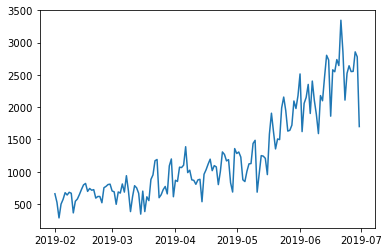

In [25]:
plt.plot(df_kpi_l[["daily_trips"]])

We then proceed to add our KPIs to our DataFrames. We also apply a moving average conversion to smooth out our data. We do this for better visibility of trends and differences between the respective cities.

### 2.1.2 Calculating KPIs

In [26]:
def add_kpis(df_kpi):
    df_kpi["trips_per_bike"] = df_kpi["daily_trips"]/df_kpi["fleet_size"]
    df_kpi["revenue_per_bike"] = df_kpi["daily_revenue"]/df_kpi["fleet_size"]
    df_kpi["revenue_per_trip"] = df_kpi["daily_revenue"]/df_kpi["daily_trips"]

    
    df_kpi["trips_per_bike_ma"] = moving_average(df_kpi["trips_per_bike"],7)
    df_kpi["revenue_per_bike_ma"] = moving_average(df_kpi["revenue_per_bike"],7)
    df_kpi["revenue_per_trip_ma"] = moving_average(df_kpi["revenue_per_trip"],7)
    
    df_kpi["daily_trips_ma"] =  moving_average(df_kpi["daily_trips"],7)
    df_kpi["daily_avg_length_ma"] = moving_average(df_kpi["daily_avg_length"],7)


add_kpis(df_kpi_l)
add_kpis(df_kpi_b)

### 2.1.3 Plotting KPIs

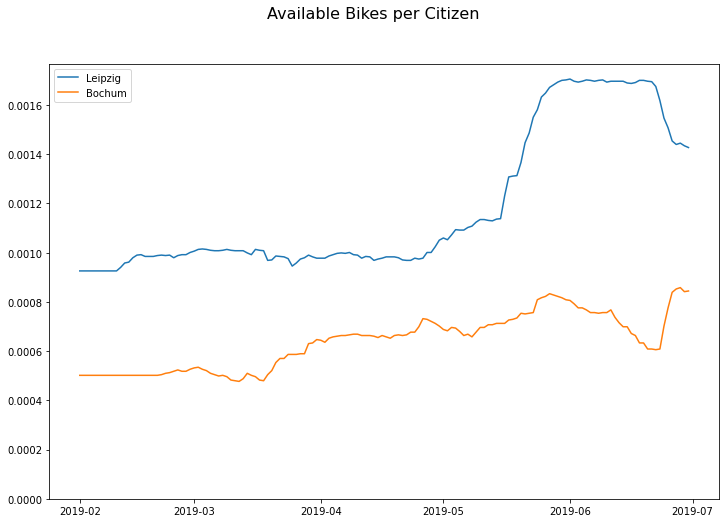

In [27]:
fig,axis = plt.subplots(1,1,figsize=(12,8))

_=axis.plot(df_kpi_l.index,(df_kpi_l["fleet_size"]/560472),label = "Leipzig") #Citizens Leipzig
_=axis.plot(df_kpi_b.index,(df_kpi_b["fleet_size"]/364742),label = "Bochum") #Citizens Bochum

axis.set_ylim(bottom=0)
axis.legend()
_=fig.suptitle("Available Bikes per Citizen", fontsize=16)

plt.savefig('./Exports/KPIs/Bikes_per_citizen.png', bbox_inches='tight')

In [28]:
def plot_kpis(df_kpi_l,df_kpi_b,kpi_name,title):
    fig,axis = plt.subplots(1,1,figsize=(12,8))
    axis.plot(df_kpi_l.index, df_kpi_l[kpi_name],label="Leipzig")
    axis.plot(df_kpi_b.index,df_kpi_b[kpi_name],label="Bochum")
    axis.set_ylim(bottom=0)
    axis.legend()
    fig.suptitle(title, fontsize=16)

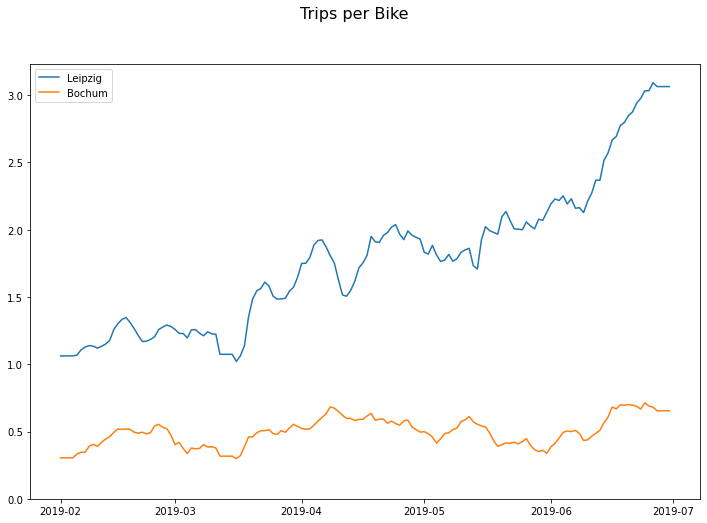

In [29]:
plot_kpis(df_kpi_l,df_kpi_b,"trips_per_bike_ma","Trips per Bike")
plt.savefig('./Exports/KPIs/Trips_per_bike.png', bbox_inches='tight')

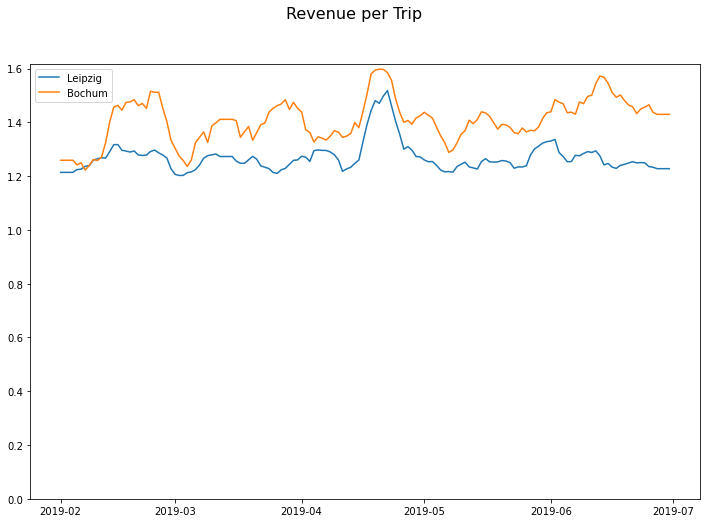

In [30]:
plot_kpis(df_kpi_l,df_kpi_b,"revenue_per_trip_ma","Revenue per Trip")
plt.savefig('./Exports/KPIs/Revenue_per_trip.png', bbox_inches='tight')

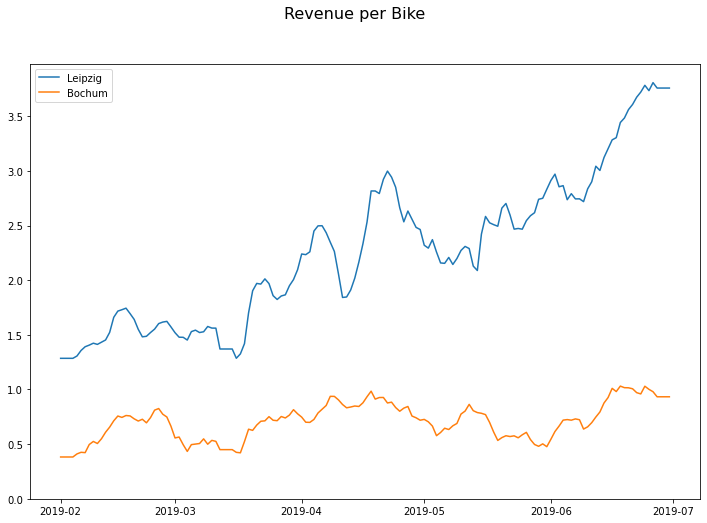

In [31]:
plot_kpis(df_kpi_l,df_kpi_b,"revenue_per_bike_ma","Revenue per Bike")
plt.savefig('./Exports/KPIs/Revenue_per_bike.png', bbox_inches='tight')

_______________________________

## 2.2 Rental Patterns

### 2.2.1 Patterns in Amount of Trips

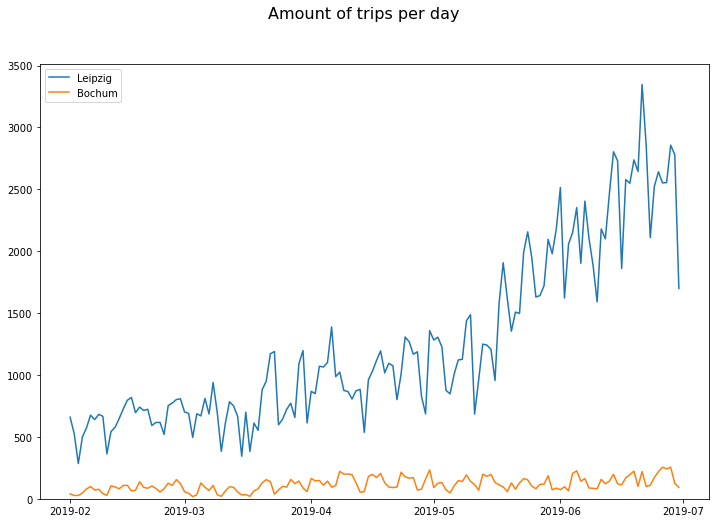

In [32]:
plot_kpis(df_kpi_l,df_kpi_b,"daily_trips","Amount of trips per day")
#plt.savefig('./Exports/Rental-Patterns/trips_total.png', bbox_inches='tight')

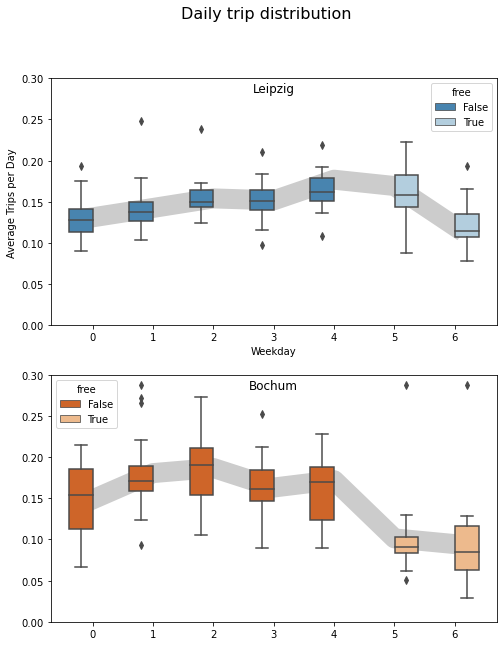

In [33]:
weekly_trend_l = df_date_l[["weekday","free","weekly_relative_trips"]]
weekly_trend_b = df_date_b[["weekday","free","weekly_relative_trips"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(8, 10))
Fig_1.suptitle('Daily trip distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
weekly_trends = [weekly_trend_l,weekly_trend_b]
for weekly_trend in weekly_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=weekly_trend, 
                     x="weekday", 
                     y="weekly_relative_trips", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    weekly_trend_avg = weekly_trend.groupby("weekday").agg(relative_trips = ("weekly_relative_trips","mean"))
    avg = axes[i].plot(weekly_trend_avg.index,
                       weekly_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 0.3))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trips per Day')
axes[0].set_xlabel('Weekday')

plt.savefig('./Exports/Rental-Patterns/trips_weekly.png', bbox_inches='tight')

### Hourly Trip distribution

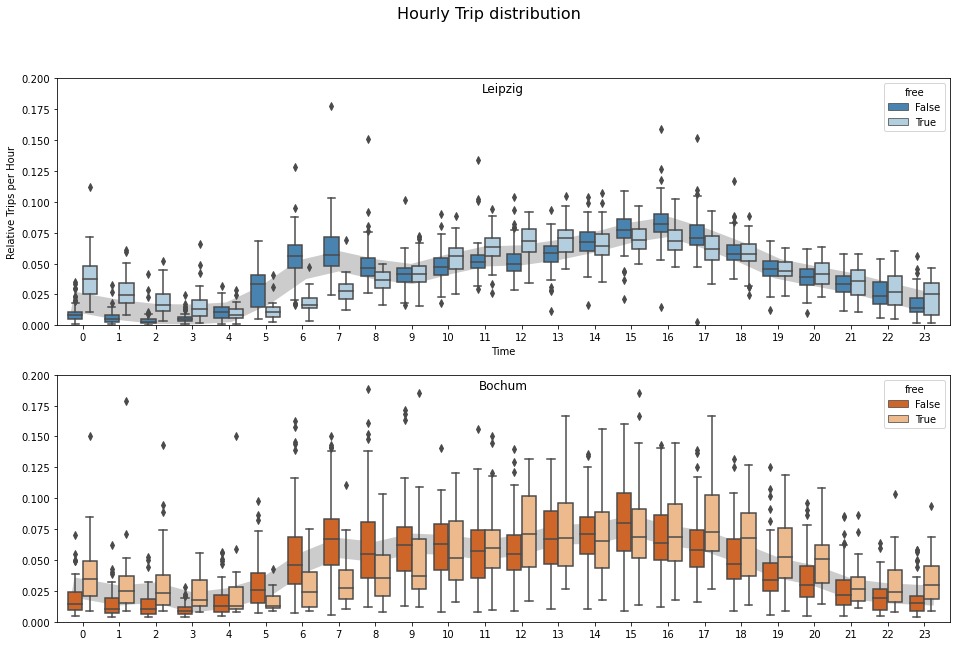

In [34]:
daily_trend_l = df_hour_l[["time","free","relative_trips"]]
daily_trend_b = df_hour_b[["time","free","relative_trips"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(16, 10))
Fig_1.suptitle('Hourly Trip distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
daily_trends = [daily_trend_l,daily_trend_b]
for daily_trend in daily_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=daily_trend, 
                     x="time", 
                     y="relative_trips", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    daily_trend_avg = daily_trend.groupby("time").agg(relative_trips = ("relative_trips","mean"))
    avg = axes[i].plot(daily_trend_avg.index,
                       daily_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 0.2))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Relative Trips per Hour')
axes[0].set_xlabel('Time')
#axes[1].legend().remove()

plt.savefig('./Exports/Rental-Patterns/trips_daily.png', bbox_inches='tight')

### 2.2.1 Patterns in Length of Trips

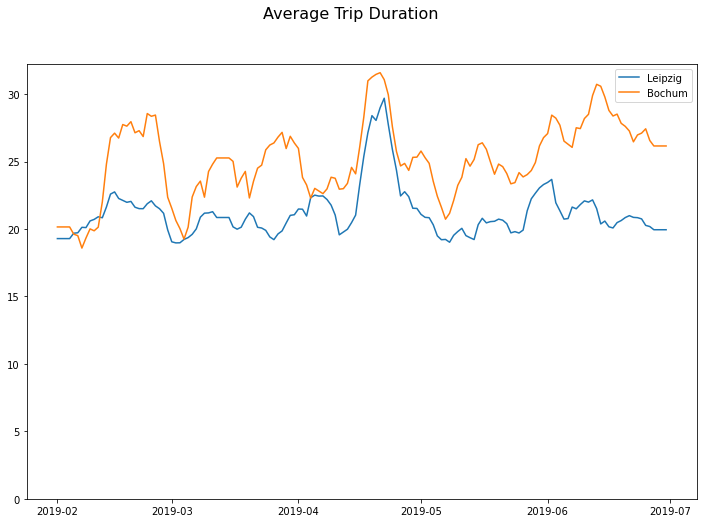

In [35]:
plot_kpis(df_kpi_l,df_kpi_b,"daily_avg_length_ma","Average Trip Duration")


plt.savefig('./Exports/Rental-Patterns/duration_total.png', bbox_inches='tight')

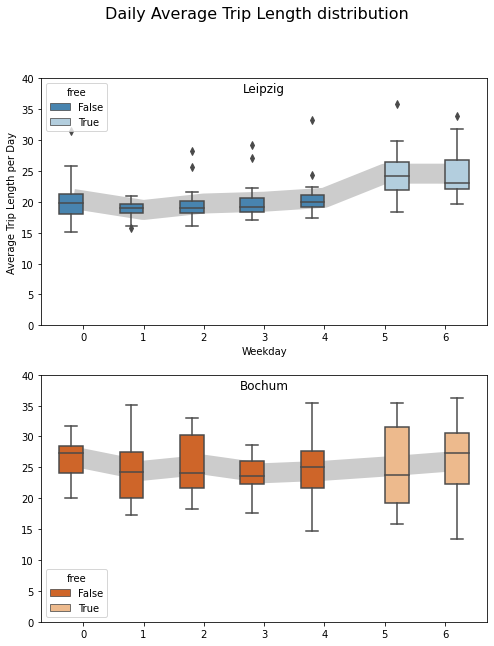

In [36]:
weekly_trend_l = df_date_l[["weekday","free","daily_avg_length"]]
weekly_trend_b = df_date_b[["weekday","free","daily_avg_length"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(8, 10))
Fig_1.suptitle('Daily Average Trip Length distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
weekly_trends = [weekly_trend_l,weekly_trend_b]
for weekly_trend in weekly_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=weekly_trend, 
                     x="weekday", 
                     y="daily_avg_length", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    weekly_trend_avg = weekly_trend.groupby("weekday").agg(relative_trips = ("daily_avg_length","mean"))
    avg = axes[i].plot(weekly_trend_avg.index,
                       weekly_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 40))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trip Length per Day')
axes[0].set_xlabel('Weekday')

plt.savefig('./Exports/Rental-Patterns/duration_weekly.png', bbox_inches='tight')

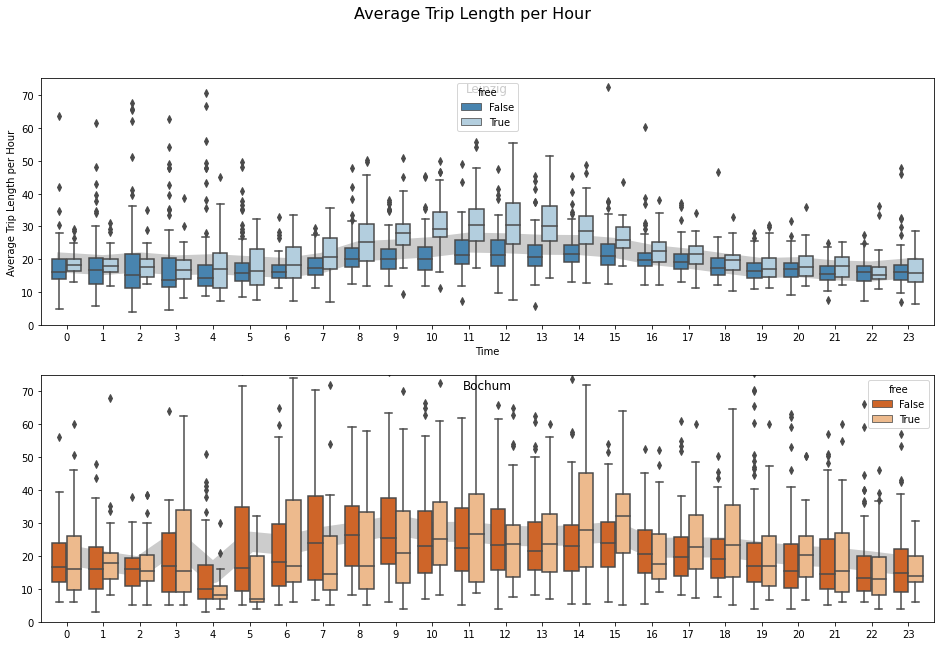

In [37]:
daily_trend_l = df_hour_l[["time","free","avg_length"]]
daily_trend_b = df_hour_b[["time","free","avg_length"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(16, 10))
Fig_1.suptitle('Average Trip Length per Hour', fontsize=16)

color_palette = "Blues_r"
i = 0
daily_trends = [daily_trend_l,daily_trend_b]
for daily_trend in daily_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=daily_trend, 
                     x="time", 
                     y="avg_length", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    daily_trend_avg = daily_trend.groupby("time").agg(relative_trips = ("avg_length","mean"))
    avg = axes[i].plot(daily_trend_avg.index,
                       daily_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 75))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trip Length per Hour')
axes[0].set_xlabel('Time')
#axes[1].legend().remove()

plt.savefig('./Exports/Rental-Patterns/duration_daily.png', bbox_inches='tight')

### 2.2.3 Geographic Rental Patterns
In this step, we plot the distribution of start and end locations of bike rentals in respect to the area. In order to reduce complexity, we focus on working days for now. We expect to see clearer patterns as we know from above that rental pattern differs between working and non-working days.

#### 2.2.3.1 Adding Area Names from Geographic Data

In [38]:
def area_array(df,polys,lng,lat):
    
    gdf = gpd.GeoDataFrame(df[[lng,lat]], geometry=gpd.points_from_xy(df[lng], df[lat]))
    
    stadtteile = []

    for index,row in gdf.iterrows():
        point = row["geometry"]
        stadtteil = None
        
        for indox,rew in polys.iterrows():
            if point.within(rew["geometry"]):
                stadtteil = rew["Name"]
                break
                
        stadtteile.append(stadtteil)
       
    return stadtteile

In [39]:
df_l["start_area"] = area_array(df_l,leipzig_map,"orig_lng","orig_lat")
df_l["end_area"] = area_array(df_l,leipzig_map,"dest_lng","dest_lat")
df_b["start_area"] = area_array(df_b,bochum_map,"orig_lng","orig_lat")
df_b["end_area"] = area_array(df_b,bochum_map,"dest_lng","dest_lat")

NameError: name 'leipzig_map' is not defined

#### 2.2.3.1 Plotting Relative Amount of Trips started by area and part of the day

In [ ]:
def plot_sliced_days(df,polys,slices,titlecity):
    slice_size = 24/slices
    fig, axes = plt.subplots(2, slices, figsize=(30,20))
    fig.suptitle('Start and End Areas on Working days, '+titlecity, fontsize=24)
    i=0
    while i < slices:
        min_time = slice_size*i
        max_time = min_time + slice_size - 1
        dfx = df[(df["Time"]>=min_time)&(df["Time"]<=max_time)]  # filter out only weekdays

        plottable_start = dfx.groupby("start_area").agg(count = ("start_area","count"))
        plottable_start = pd.merge(polys, plottable_start, left_on="Name", right_index=True)
        
        plottable_end = dfx.groupby("end_area").agg(count = ("end_area","count"))
        plottable_end = pd.merge(polys, plottable_end, left_on="Name", right_index=True)
            
        plottable_start.plot(ax=axes[0,i], alpha=0.8, edgecolor='darkgrey',cmap="Blues",column='count', zorder=1,  legend=False)
        ctx.add_basemap(ax=axes[0,i],crs=4326)
        polys.plot(ax=axes[0,i],zorder=3,alpha=0)
        axes[0,i].set_title('Start, '+str(min_time)+"h to " + str(max_time) + "h")
        
        plottable_end.plot(ax=axes[1,i], alpha=0.8, edgecolor='darkgrey',cmap="Blues",column='count', zorder=1,  legend=False)
        ctx.add_basemap(ax=axes[1,i],crs=4326)
        polys.plot(ax=axes[1,i],zorder=3,alpha=0)
        axes[1,i].set_title('End, '+str(min_time)+"h to " + str(max_time) + "h")
        i = i + 1
    
    ylim1,ylim2 = axes[0,0].get_ylim()
    xlim1,xlim2 = axes[0,0].get_xlim()

    for axis in axes[0]:
        axis.set_ylim(ylim1,ylim2)
        axis.set_xlim(xlim1,xlim2)
    for axis in axes[1]:
        axis.set_ylim(ylim1,ylim2)
        axis.set_xlim(xlim1,xlim2)

In [ ]:
plot_sliced_days(df=df_l[df_l["free"]==False],polys=leipzig_map,slices=3,titlecity="Leipzig")

plt.savefig('./Exports/Rental-Patterns/geo_areas_leipzig.png', bbox_inches='tight')


In [ ]:
plot_sliced_days(df=df_b[df_b["free"]==False],polys=bochum_map,slices=3,titlecity="Bochum")

plt.savefig('./Exports/Rental-Patterns/geo_areas_bochum.png', bbox_inches='tight')


While the outcomes for Leipzig are quite detailed and allow for the conclusion that Nextbikes bikes are used to commute into the city in the morning and from the city in the evening, the area segments in the available Bochum map material seem to be too large to see such clear rental patterns. 

To solve this, we used KDE plotting from the Seaborn Library to produce a Heatmap-like Histogram that shows the same patterns without aggregating data to the respective areas.

#### 2.2.3.2 Plotting Relative Amount of Trips started by part of the day - Heatmap approach

In [ ]:
def plot_locs_split(df,polys,splits,zoom,figsize,titlecity):
    slice_size = 24/splits
    fig, axes = plt.subplots(2,splits,figsize=figsize)
    fig.suptitle('Start and End Areas on Working days, '+titlecity, fontsize=24)
    
    polys.plot(ax=axes[0,0],zorder=1,alpha=0)

    xlim1,xlim2 = axes[0,0].get_xlim()
    ylim1,ylim2 = axes[0,0].get_ylim()
    
    xmid = xlim1+(xlim2-xlim1)/2
    ymid = ylim1+(ylim2-ylim1)/2
 
    
    #zoom feature
    xlim1 = xmid + (xlim1-xmid)/zoom
    xlim2 = xmid + (xlim2-xmid)/zoom
    ylim1 = ymid + (ylim1-ymid)/zoom
    ylim2 = ymid + (ylim2-ymid)/zoom


    i = 0
    while i < splits:

        min_time = i*slice_size
        max_time = (i+1)*slice_size - 1
        df_split = df[(df["Time"]>=min_time) & (df["Time"]<=max_time)] # filter for specific quarter of day

        u=0
        while u<2:
            polys.plot(ax=axes[u,i],zorder=1,alpha=0)
            # Plotting the KDE Plot as a heatmap


            lng = "orig_lng"
            lat = "orig_lat"
            if u ==1:
                lng = "dest_lng"
                lat = "dest_lat"

            sns.kdeplot(x=df_split[lng],
                        y=df_split[lat],
                        shade=True,
                        thresh=0.1,
                        cmap="hot",
                        ax=axes[u,i]) 

            ctx.add_basemap(ax=axes[u,i],crs=4326,alpha=0.8)
            polys.plot(ax=axes[u,i],zorder=1,facecolor="none", edgecolor="black")

            axes[u,i].set_ylim(ylim1,ylim2)
            axes[u,i].set_xlim(xlim1,xlim2)
            
            axes[u,i].set_axis_off()
            
            u = u + 1
        
        axes[0,i].set_title(str(int(min_time))+" to "+str(int(max_time))+" O'Clock")

        i = i + 1



In [ ]:
plot_locs_split(df=df_b[df_b["free"]==False],polys=bochum_map,splits=3,zoom=1,figsize=(30,15),titlecity="Bochum") 

plt.savefig('./Exports/Rental-Patterns/geo_heatmap_bochum.png', bbox_inches='tight')

In [ ]:
plot_locs_split(df=df_l[df_l["free"]==False],polys=leipzig_map,splits=3,zoom=1.3,figsize=(20,15),titlecity="Leipzig")

plt.savefig('./Exports/Rental-Patterns/geo_heatmap_leipzig.png', bbox_inches='tight')

____

# 3. Clustering

## 3.1 Preparing Dataset

In [ ]:
df_clustering_b = df_b[["Time_float",
                        "dest_lng",
                        "dest_lat",
                        "orig_lng",
                        "orig_lat",
                        "distance_traveled",
                        "trip_duration_minutes",
                        "free",
                       "start_distance_center"]]
df_clustering_b_free = df_clustering_b[df_clustering_b["free"]==True]
df_clustering_b_work = df_clustering_b[df_clustering_b["free"]==False]

df_clustering_l = df_l[["Time_float",
                        "dest_lng",
                        "dest_lat",
                        "orig_lng",
                        "orig_lat",
                        "distance_traveled",
                        "trip_duration_minutes",
                        "free",
                        "start_distance_center"]]

df_clustering_l_free = df_clustering_l[df_clustering_l["free"]==True]
df_clustering_l_work = df_clustering_l[df_clustering_l["free"]==False]

## 3.2 Location based Clustering
Based on the insight from geographical rental patterns, we try to derive meaningful clusters of customers from our data. Our approach is to look at start locations on working days and build types of customers based on when they start their rides where. Based on our prior analysis, we would for example expect a concentration of start locations towards the city centre in Leipzig.

In [ ]:
def location_clustering_3d(df_clustering,n,lng,lat,title):
    
    df_clustering= df_clustering[["Time_float",lng,lat]]
    fig = plt.figure(figsize =(10,12))
    fig.suptitle(title,fontsize=12)
    axis1 = fig.add_axes([0, 1, 0.2, 0.1]) # main axes
    axis2 = fig.add_axes([0, 1, 1, 1],projection='3d') # added axes
    #axis1 = fig.add_subplot()
    #axis2 = fig.add_subplot(projection='3d')
    
    df_clustering_n = min_max_scaling(df_clustering)

    ssd = []
    
    for i in range(2, 15):
        km = MiniBatchKMeans(n_clusters=i)
        km.fit_predict(df_clustering_n)
        ssd.append(km.inertia_)

    ssd=pd.DataFrame(ssd)
    ssd.columns = ["ssd"]

    axis1.plot(ssd)
    
    
    km = KMeans(n_clusters=n)
    labels = km.fit_predict(df_clustering_n)

    
    
    _ = axis2.scatter(df_clustering["Time_float"],
                      df_clustering[lng],
                      df_clustering[lat],
                      s = 2,
                      c=labels,
                      alpha=1)

    axis2.invert_xaxis()
    
    plt.show()

In [ ]:
location_clustering_3d(df_clustering_l_work,5,"orig_lng","orig_lat","Origin Coordinates in relation to Time, Leipzig")

In [ ]:
location_clustering_3d(df_clustering_b_work,5,"orig_lng","orig_lat","Origin Coordinates in relation to Time, Bochum")

While this produces clusters in a way, we cannot really see any meaningful cluster points that can be interpreted well. We instead try to work with the distance to the city center in order to produce more meaningful clusters.

In [ ]:
def clustering_2d(df,feature1,feature2,n,title):
    fig,ax=plt.subplots(1,3,figsize=(18,6))
    fig.suptitle(title, fontsize=14)
    

    df_clustering = df[[feature1,feature2]]
    df_clustering_n = min_max_scaling(df_clustering)
    
    #L Curve
    ssd = []
    for i in range(2, 15):
        km = KMeans(n_clusters=i)
        km.fit_predict(df_clustering_n)
        ssd.append(km.inertia_)
    ax[1].plot(ssd)
        
    #Fit model 
    km = KMeans(n_clusters=n)
    labels = km.fit_predict(df_clustering_n)
    
    ax[0].scatter(x=df_clustering[feature1],y=df_clustering[feature2],c=labels,alpha=0.05)
    
    _ = ax[2].hist2d(df_clustering[feature1],
                df_clustering[feature2],
                bins=59,cmap="Blues", 
               )
    
    ax[0].set_title("Clusters")
    ax[1].set_title("L_Curve")
    ax[2].set_title("Histogram")
    
    ax[0].set_ylabel(feature2)
    ax[0].set_xlabel(feature1)
    
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("k")
    
    ax[2].set_ylabel(feature2)
    ax[2].set_xlabel(feature1)

In [ ]:
clustering_2d(df_clustering_b,"Time_float","start_distance_center",2,"Start Time in relation to distance to city centre, Bochum (k=2)")

plt.savefig('./Exports/Clustering/time_startdistance_bochum.png', bbox_inches='tight')

In [ ]:
clustering_2d(df_clustering_l,"Time_float","start_distance_center",4,"Start Time in relation to distance to city centre, Leipzig(k=4)")

plt.savefig('./Exports/Clustering/time_startdistance_leipzig.png', bbox_inches='tight')

## Trip Type Clustering

In [ ]:
clustering_2d(df_clustering_b,"trip_duration_minutes","distance_traveled",4,"Trip duration in relation to distance traveled, Bochum (k=4)")

plt.savefig('./Exports/Clustering/duration_distance_bochum.png', bbox_inches='tight')

In [ ]:
clustering_2d(df_clustering_l,"trip_duration_minutes","distance_traveled",5,"Trip duration in relation to distance traveled, Leipzig (k=5)")

plt.savefig('./Exports/Clustering/duration_distance_leipzig.png', bbox_inches='tight')

# Predictive Analytics

## 4.1 Data Preparation
In this step, we need to add weather data to our existing features. While the DWD offers a lot of raw data, it is difficult to find daily weather data for our specific cities and would involve a lot of processing. We find that using data from meteostat makes this a lot easier as the processing is already done.

In [54]:
#Meteostat Data read-in
meteostat_l = pd.read_csv("./weather-data/meteostat-leipzig.csv") 
meteostat_l.index = dates
meteostat_l.drop(columns=["wpgt","wdir","date"],inplace=True)

meteostat_b = pd.read_csv("./weather-data/meteostat-bochum.csv") 
meteostat_b.index = dates
meteostat_b.drop(columns=["wpgt","wdir","date"],inplace=True)

### 4.1.1 Comparison of Meteostat to DWD precipitation Data
The DWD offers rasterised daily precipitation for raster points throughout Germany. However, this data is in an uncommon format and had to be processed with a customised Python script. The code below shows that the precipitation data unconveniently gathered strongly resembles the data that we got from meteostat. We derive that Meteostat has accurate weather data that we can use in our predictive analytics.

C:\Users\Install\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


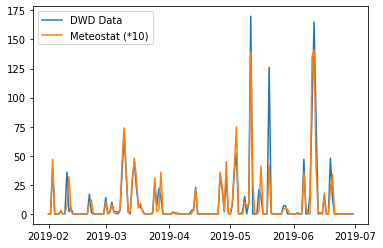

In [55]:
#Calculating the best Raster Point that is closest to the city center
testset_weather = pd.read_csv("./weather-data/dwd-raster/target/ra190201_target.csv") 

distances_center = []
for index, row in testset_weather.iterrows():
        d = {
            "LON": row["LON"],
            "LAT": row["LAT"],
            "ID": row["ID"],
            "distance": calculate_distance(row["LON"], row["LAT"], leipzig["lng"], leipzig["lat"])
        } 
        distances_center.append(d)
distances_center = pd.DataFrame(distances_center)

raster_id = distances_center.iloc[distances_center["distance"].idxmin()]["ID"]

#Read in CDC Raster Data from single files and Filter for the calculated point
import os

path = './weather-data/dwd-raster/target/'
rain_data_all = pd.concat((pd.read_csv(path+filename) for filename in os.listdir(path)))

rain_data = rain_data_all[rain_data_all["ID"] == raster_id]
rain_data.index = dates #indexing
rain_data.drop(columns=["ID"],inplace=True) 

#meteostat_leipzig.isnull().sum().sort_values(ascending=False)

plt.plot(rain_data.index,rain_data.VAL,label="DWD Data")
plt.plot(meteostat_l.index,meteostat_l.prcp*10, label="Meteostat (*10)")
plt.legend()

### 4.1.2 Building DataFrame

In [65]:
def df_predictive(df,meteostat):
    df["free_dummy"] = df["free"].astype(int)
    df = df.join(meteostat)
    df = df.drop(columns={"snow","free","daily_usage","weekday","daily_avg_length","weekly_trips","weekly_relative_trips","daily_revenue","daily_used_bikes"})
    return df

df_predictive_l = df_predictive(df_date_l,meteostat_l)
df_predictive_b = df_predictive(df_date_b,meteostat_b)

df_predictive_l

,week,daily_trips,fleet_size,free_dummy,tavg,tmin,tmax,prcp,wspd,pres,tsun
date,,,,,,,,,,,
2019-02-01,5,659,519,0,0.7,-2.3,3.3,0.0,6,995.2,0
2019-02-02,5,526,519,1,1.2,0.7,1.6,0.0,5,997.3,0
2019-02-03,5,285,519,1,0.7,0.2,1.1,4.7,11,1013.9,0
2019-02-04,6,499,519,0,0.8,-1.6,4.7,0.0,9,1028.2,470
2019-02-05,6,573,519,0,1.4,-0.5,3.8,0.0,9,1027.9,2
...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,26,2552,815,0,29.4,21.5,36.6,0.0,14,1020.1,750
2019-06-27,26,2555,807,0,20.5,15.3,26.2,0.0,17,1023.9,768
2019-06-28,26,2857,810,0,18.2,13.5,24.0,0.0,7,1024.5,513


## 4.2 Feature Selection
For regression problems, it is a good idea to minimise features by finding features that essentially mean the same thing. In this case, we find that we can eliminate the minimum temperature and maximum temperature as they are highly correlated with the average temperature, which obviously makes sense. In other cases, there is a high correlation between e.g. the fleet size and the the average temperature in Leipzig - this is very likely due to the fleet size being scaled up in the same time as temperatures rose. But from human intuition, it is not very plausible that these two things are connected. So we don't eliminate further.

Text(0.5, 1.0, 'Bochum')

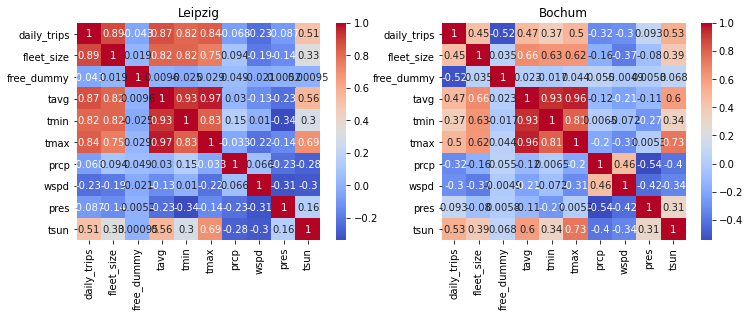

In [66]:
fig,ax  = plt.subplots(1,2,figsize=(12,4))
sns.heatmap(df_predictive_l.corr(), annot=True,cmap ="coolwarm",ax=ax[0])
sns.heatmap(df_predictive_b.corr(), annot=True,cmap ="coolwarm",ax=ax[1])

ax[0].set_title("Leipzig")
ax[1].set_title("Bochum")

#plt.savefig('./Exports/Predictive/Correlation_Analysis_before.png', bbox_inches='tight')

Text(0.5, 1.0, 'Bochum')

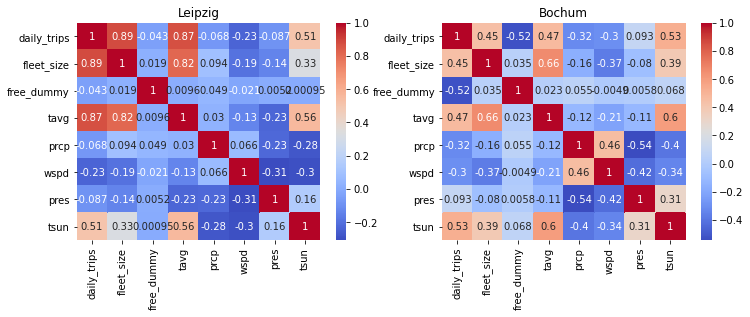

In [67]:
df_predictive_l = df_predictive_l.drop(columns=["tmin","tmax"])
df_predictive_b = df_predictive_b.drop(columns=["tmin","tmax"])

fig,ax  = plt.subplots(1,2,figsize=(12,4))
sns.heatmap(df_predictive_l.corr(), annot=True,cmap ="coolwarm",ax=ax[0])
sns.heatmap(df_predictive_b.corr(), annot=True,cmap ="coolwarm",ax=ax[1])

ax[0].set_title("Leipzig")
ax[1].set_title("Bochum")

#plt.savefig('./Exports/Predictive/Correlation_Analysis_after.png', bbox_inches='tight')

In [68]:
X_b = df_predictive_b.drop(columns=["daily_trips"])
Y_b = df_predictive_b[["daily_trips"]]

X_b_n =  min_max_scaling(X_b)

X_b_train, X_b_test, Y_b_train, Y_b_test = train_test_split(X_b_n, Y_b,test_size = 0.3)

X_l = df_predictive_l.drop(columns=["daily_trips"])
Y_l = df_predictive_l[["daily_trips"]]

X_l_n =  min_max_scaling(X_l)

X_l_train, X_l_test, Y_l_train, Y_l_test = train_test_split(X_l_n, Y_l,test_size = 0.3)

In [69]:
def tree_regression(Xtrain, Ytrain,Xtest, Ytest, min_leaves, xlabel, ylabel):
    Tree_reg = DecisionTreeRegressor(min_samples_leaf=min_leaves,criterion="mse")
    Tree_reg.fit(Xtrain, Ytrain)
    Y_pred = Tree_reg.predict(Xtest)
    
    r2= r2_score(Ytest, Y_pred)
    return r2

r2values=[]
i = 1
while i < 70:
    r2values.append(tree_regression(Xtrain = X_train, 
                                    Ytrain = Y_train,
                                    Xtest = X_test,
                                    Ytest =  Y_test, 
                                    min_leaves = i, 
                                    xlabel = "Avg Temperature", 
                                    ylabel = "Daily Trips"))
    i += 1
    
plt.plot(r2values)
r2max = np.argmax(r2values, axis=0) + 1
print("best r2 is at:", r2max,":", max(r2values))

NameError: name 'X_train' is not defined

In [ ]:
Tree_reg = DecisionTreeRegressor(min_samples_leaf=5,criterion="mse")
Tree_reg.fit(X_train, Y_train)
Y_pred = Tree_reg.predict(X_test)

test_set_r2 = r2_score(Y_test, Y_pred)
plt.scatter(Y_test, Y_pred)

max=Y_test.max()["daily_trips"]
x = np.linspace(0, max,max)
print("R2:", test_set_r2)
plt.plot(x,x)

In [ ]:
lin_reg_mod = LinearRegression(normalize=True)
lin_reg_mod.fit(X_train, Y_train)
pred = lin_reg_mod.predict(X_test)

test_set_r2 = r2_score(Y_test, pred)
plt.scatter(Y_test, pred)


max=Y_test.max()["daily_trips"]
x = np.linspace(0, max, max)
print("R2:", test_set_r2)
plt.plot(x,x)

In [ ]:
pd.DataFrame(index=X_n.columns,data = lin_reg_mod.coef_.reshape(-1,1))


### Seasonal ARIMA Prediction Model

In [75]:
#select column "daily trips" for ARIMA prediction model
df_arima_l = df_kpi_l[["daily_trips"]]
df_arima_b = df_kpi_b[["daily_trips"]]

In [159]:
df_arima_l

,daily_trips
2019-02-01,659
2019-02-02,526
2019-02-03,285
2019-02-04,499
2019-02-05,573
...,...
2019-06-26,2552
2019-06-27,2555
2019-06-28,2857
2019-06-29,2780


In [160]:
#import libraries
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

First and foremost is to simple plot the data and analyze visually.

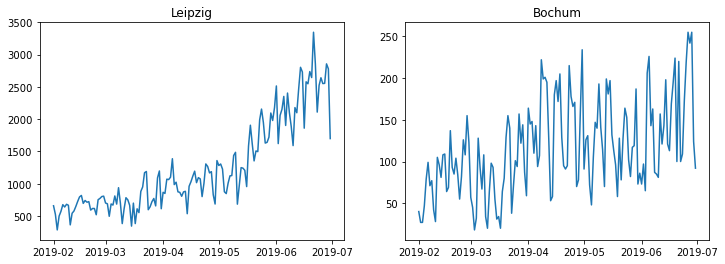

In [161]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].set_title("Leipzig")
axes[0].plot(df_arima_l)
axes[1].set_title("Bochum")
axes[1].plot(df_arima_b)

It looks like there is an overall increasing trend in data along with some seasonal variations, especially in Leipzig. Now, we can check the stationarity using 1) Plotting Rolling Statistics or 2) Dickey-Fuller Test
We used a function (from the Workshop) which takes a Time Series as input and generated it for us. We’ve plotted standard deviation instead of variance to keep the unit similar to mean

In [162]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [163]:
adfuller(df_arima_l['daily_trips'])

(0.8660025381641807,
 0.9926302173972272,
 14,
 135,
 {'1%': -3.479742586699182,
  '5%': -2.88319822181578,
  '10%': -2.578319684499314},
 1874.3739580302326)

In [164]:
adfuller(df_arima_b['daily_trips'])

(-1.494837289186767,
 0.5360636946203828,
 7,
 142,
 {'1%': -3.477261624048995,
  '5%': -2.8821181874544233,
  '10%': -2.5777431104939494},
 1388.943913365928)

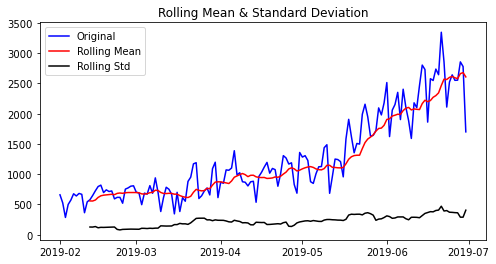

Results of Dickey-Fuller Test:

Test Statistic                   0.866003
p-value                          0.992630
#Lags Used                      14.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64


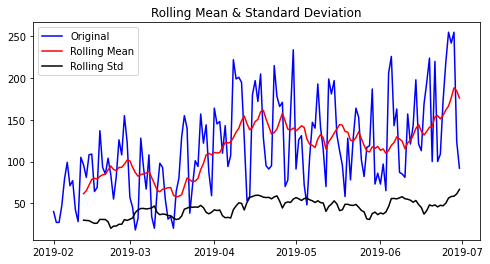

Results of Dickey-Fuller Test:

Test Statistic                  -1.494837
p-value                          0.536064
#Lags Used                       7.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [165]:
#Leipzig
test_stationarity(df_arima_l['daily_trips'])

#Bochum
test_stationarity(df_arima_b['daily_trips'])

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series for both cities. Also, the test statistic is way more than the critical values. Important : the signed values should be compared and not the absolute values.


## Make the Time Series Stationary

#### What is making a Time Series non-stationary? There are 2 major reasons behind non-stationarity of a Time Series
1)Trend – varying mean over time. For e.g., in this case we saw that on average, the daily trips were growing over time.

2)Seasonality – variations at specific time-frames. e.g. people might have a tendency to rent bikes more in rush hours on working days than at night

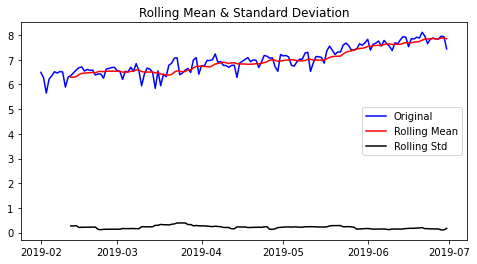

Results of Dickey-Fuller Test:

Test Statistic                  -0.427248
p-value                          0.905449
#Lags Used                       6.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


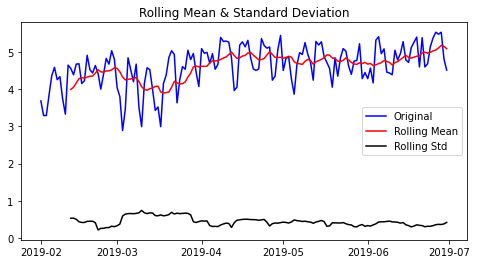

Results of Dickey-Fuller Test:

Test Statistic                  -1.758386
p-value                          0.401309
#Lags Used                       7.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [166]:
#Leipzig
ts_log_l = np.log(df_arima_l['daily_trips'])
test_stationarity(ts_log_l)
#Bochum
ts_log_b = np.log(df_arima_b['daily_trips'])
test_stationarity(ts_log_b)

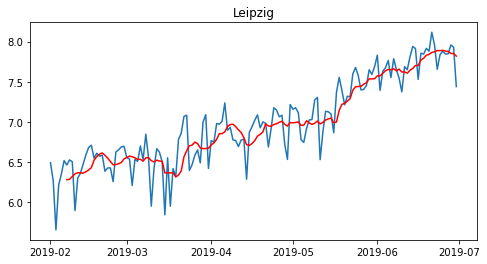

In [167]:
moving_avg_l = ts_log_l.rolling(7).mean()
plt.title("Leipzig")
plt.plot(ts_log_l)
plt.plot(moving_avg_l, color='red')

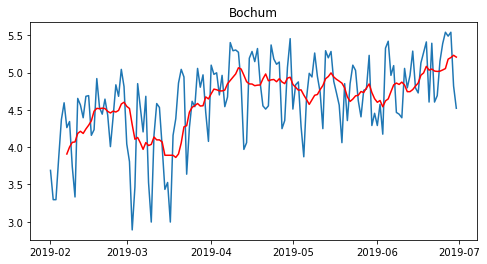

In [168]:
moving_avg_b = ts_log_b.rolling(7).mean()
plt.title("Bochum")
plt.plot(ts_log_b)
plt.plot(moving_avg_b, color='red')

In [169]:
#Leipzig
ts_log_l_moving_avg_diff = ts_log_l - moving_avg_l
ts_log_l_moving_avg_diff.head(12)

2019-02-01         NaN
2019-02-02         NaN
2019-02-03         NaN
2019-02-04         NaN
2019-02-05         NaN
2019-02-06         NaN
2019-02-07    0.182944
2019-02-08    0.241605
2019-02-09    0.185438
2019-02-10   -0.457508
2019-02-11   -0.066873
2019-02-12   -0.005650
Name: daily_trips, dtype: float64

In [170]:
#Bochum
ts_log_b_moving_avg_diff = ts_log_b - moving_avg_b
ts_log_b_moving_avg_diff.head(12)

2019-02-01         NaN
2019-02-02         NaN
2019-02-03         NaN
2019-02-04         NaN
2019-02-05         NaN
2019-02-06         NaN
2019-02-07    0.354402
2019-02-08    0.341966
2019-02-09   -0.327289
2019-02-10   -0.737949
2019-02-11    0.468976
2019-02-12    0.351521
Name: daily_trips, dtype: float64

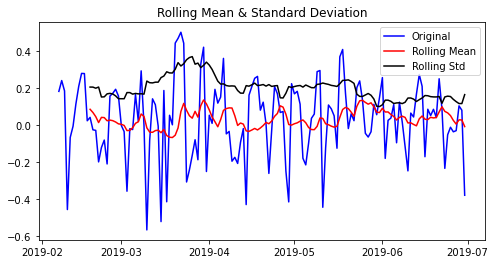

Results of Dickey-Fuller Test:

Test Statistic                  -3.243879
p-value                          0.017581
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [171]:
#Leipzig
ts_log_l_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_l_moving_avg_diff)

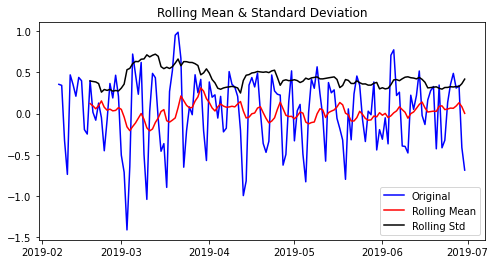

Results of Dickey-Fuller Test:

Test Statistic                  -2.584453
p-value                          0.096253
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [172]:
#Bochum
ts_log_b_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_b_moving_avg_diff)

The rolling values appear to be varying but there is no specific trend. For Leipzig, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.For Bochum, the test statistic is smaller than the 10% critical values so we can say with 90% confidence that this is a stationary series.

## Eliminating Trend and Seasonality

#### Ways of removing trend and seasonality:
1)Differencing – taking the differece with a particular time lag

2)Decomposition – modeling both trend and seasonality and removing them from the model.

In [173]:
#Leipzig
ts_log_l.shift(periods=1)

2019-02-01         NaN
2019-02-02    6.490724
2019-02-03    6.265301
2019-02-04    5.652489
2019-02-05    6.212606
                ...   
2019-06-26    7.879291
2019-06-27    7.844633
2019-06-28    7.845808
2019-06-29    7.957527
2019-06-30    7.930206
Name: daily_trips, Length: 150, dtype: float64

In [174]:
#Bochum
ts_log_b.shift(periods=1)

2019-02-01         NaN
2019-02-02    3.688879
2019-02-03    3.295837
2019-02-04    3.295837
2019-02-05    3.850148
                ...   
2019-06-26    5.389072
2019-06-27    5.541264
2019-06-28    5.488938
2019-06-29    5.541264
2019-06-30    4.820282
Name: daily_trips, Length: 150, dtype: float64

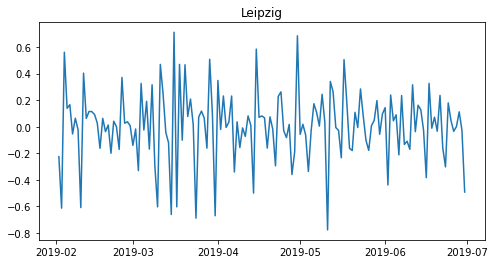

In [175]:
ts_log_l_diff = ts_log_l - ts_log_l.shift()
plt.title("Leipzig")
plt.plot(ts_log_l_diff)

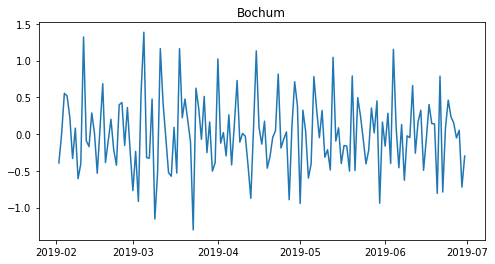

In [176]:
ts_log_b_diff = ts_log_b - ts_log_b.shift()
plt.title("Bochum")
plt.plot(ts_log_b_diff)

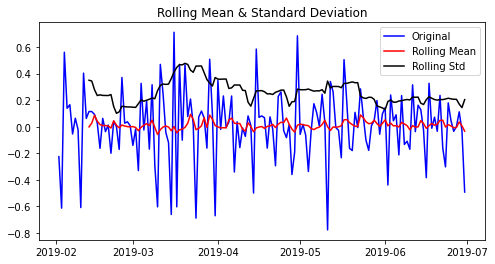

Results of Dickey-Fuller Test:

Test Statistic                -1.055008e+01
p-value                        8.219206e-19
#Lags Used                     5.000000e+00
Number of Observations Used    1.430000e+02
Critical Value (1%)           -3.476927e+00
Critical Value (5%)           -2.881973e+00
Critical Value (10%)          -2.577665e+00
dtype: float64


In [177]:
#Leipzig
ts_log_l_diff.dropna(inplace=True)
test_stationarity(ts_log_l_diff)

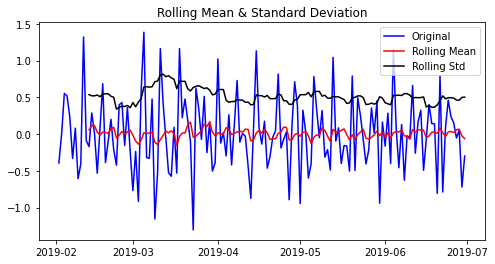

Results of Dickey-Fuller Test:

Test Statistic                  -3.204674
p-value                          0.019716
#Lags Used                      14.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


In [178]:
#Bochum
ts_log_b_diff.dropna(inplace=True)
test_stationarity(ts_log_b_diff)

We can see that the mean and std variations have some variations with time. Also, the Dickey-Fuller test statistic is less than the 1% critical value for Leipzig, thus the Time Series is stationary with 99% confidence. For Bochum, the Dickey-Fuller test statistic is less than the 5% critical value, thus the Time Series ist stationary with 95% confidence.

2) Decomposition

<ipython-input-179-dcb9e47a6db7>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(ts_log_l, model = 'additive', freq = 30,extrapolate_trend = 30) #Seasonal decomposition using moving averages


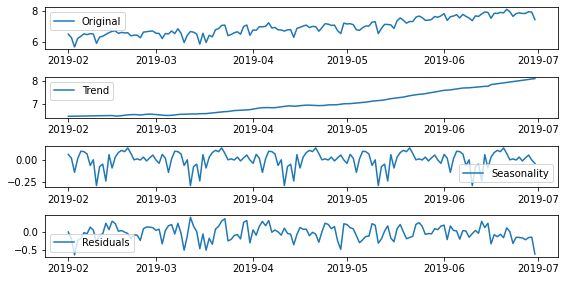

In [179]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log_l, model = 'additive', freq = 30,extrapolate_trend = 30) #Seasonal decomposition using moving averages

trend_l = decomposition.trend
seasonal_l = decomposition.seasonal
residual_l = decomposition.resid

plt.title("Leipzig")
plt.subplot(411)
plt.plot(ts_log_l, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_l, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_l,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_l, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<ipython-input-180-e2fb6a141849>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(ts_log_b, model = 'additive', freq=30, extrapolate_trend = 30) #Seasonal decomposition using moving averages


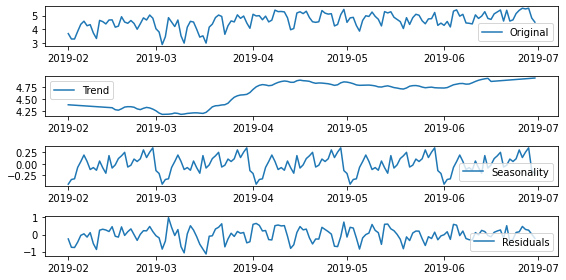

In [180]:
decomposition = seasonal_decompose(ts_log_b, model = 'additive', freq=30, extrapolate_trend = 30) #Seasonal decomposition using moving averages

trend_b = decomposition.trend
seasonal_b = decomposition.seasonal
residual_b = decomposition.resid

plt.title("Bochum")
plt.subplot(411)
plt.plot(ts_log_b, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_b, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_b,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_b, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

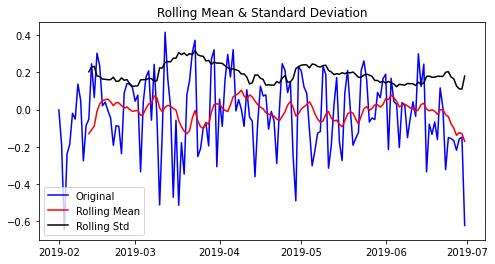

Results of Dickey-Fuller Test:

Test Statistic                  -2.355128
p-value                          0.154804
#Lags Used                      14.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64


In [181]:
#Leipzig
ts_log_l_decompose = residual_l
ts_log_l_decompose.dropna(inplace=True)
test_stationarity(ts_log_l_decompose)

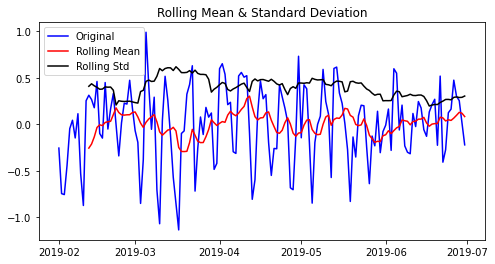

Results of Dickey-Fuller Test:

Test Statistic                  -4.718106
p-value                          0.000078
#Lags Used                       9.000000
Number of Observations Used    140.000000
Critical Value (1%)             -3.477945
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
dtype: float64


In [182]:
#Bochum
ts_log_b_decompose = residual_b
ts_log_b_decompose.dropna(inplace=True)
test_stationarity(ts_log_b_decompose)

With the Decomposition method, we can see that the Dickey-Fuller test statistic is not significantly lower than any critical value for Leipzig just for Bochum. Thus we think that the Differencing method is the right one to use in our case.

## Forecasting a Time Series

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots (ACF and PACF) to determine these numbers. 

In [183]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [184]:
#Leipzig
lag_acf_l = acf(ts_log_l_diff, nlags=20)
lag_pacf_l = pacf(ts_log_l_diff, nlags=20, method='ols')

#Bochum
lag_acf_b = acf(ts_log_b_diff, nlags=20)
lag_pacf_b = pacf(ts_log_b_diff, nlags=20, method='ols')

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function (Leipzig)')

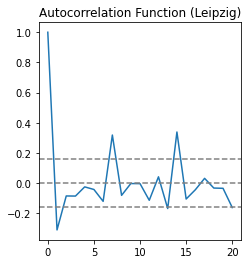

In [185]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf_l)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_l_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_l_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function (Leipzig)')

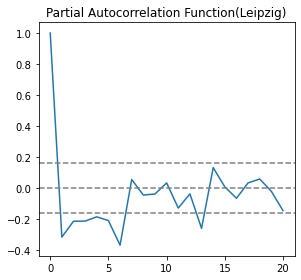

In [186]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_l)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_l_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_l_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function(Leipzig)')
plt.tight_layout()

Text(0.5, 1.0, 'Autocorrelation Function (Bochum)')

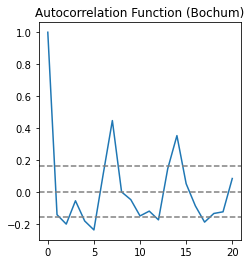

In [187]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf_b)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_b_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_b_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function (Bochum)')

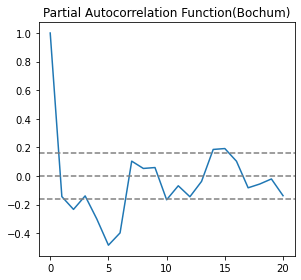

In [188]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_b)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_b_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_b_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function(Bochum)')
plt.tight_layout()

In these two plots for each city, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in our both cases (Leipzig and Bochum) p=1.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in our both cases (Leipzig and Bochum) q=1.

In [197]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D

Text(0.5, 1.0, 'RSS: 9.5361')

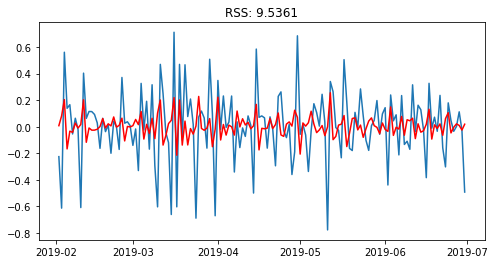

In [198]:
#AR Model Leipzig
model_l = ARIMA(ts_log_l, order=(1, 1, 0))  
results_AR_l = model_l.fit(disp=-1)  
plt.plot(ts_log_l_diff)
plt.plot(results_AR_l.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_l.fittedvalues-ts_log_l_diff)**2))

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import 

Text(0.5, 1.0, 'RSS: nan')

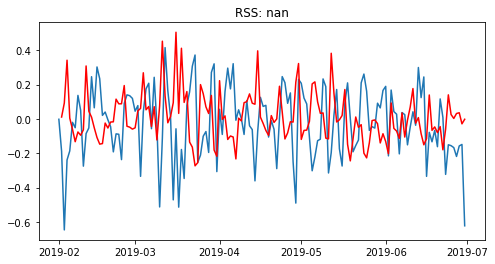

In [199]:
#MA Model Leipzig
model_l = ARIMA(ts_log_l, order=(1, 1, 1))  
results_MA_l = model_l.fit(disp=-1)  
plt.plot(ts_log_l_decompose)
plt.plot(results_MA_l.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA_l.fittedvalues-ts_log_l_decompose)**2))

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import 

Text(0.5, 1.0, 'RSS: 7.6268')

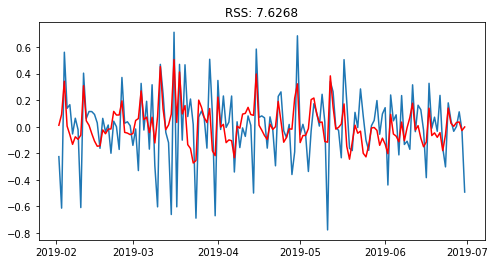

In [200]:
#ARIMA Model Leipzig
model_l = ARIMA(ts_log_l, order=(1, 1, 1))  
results_ARIMA_l = model_l.fit(disp=-1)  
plt.plot(ts_log_l_diff)
plt.plot(results_ARIMA_l.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_l.fittedvalues-ts_log_l_diff)**2))

In [201]:
predictions_ARIMA_diff_l = pd.Series(results_ARIMA_l.fittedvalues, copy=True)
predictions_ARIMA_diff_l.head()

2019-02-02    0.010742
2019-02-03    0.092486
2019-02-04    0.341727
2019-02-05    0.004596
2019-02-06   -0.060412
dtype: float64

In [203]:
predictions_ARIMA_diff_cumsum_l = predictions_ARIMA_diff_l.cumsum()
predictions_ARIMA_diff_cumsum_l.head()

2019-02-02    0.010742
2019-02-03    0.103228
2019-02-04    0.444955
2019-02-05    0.449551
2019-02-06    0.389139
dtype: float64

In [204]:
predictions_ARIMA_log_l = pd.Series(ts_log_l.iloc[0], index=ts_log_l.index)
predictions_ARIMA_log_l = predictions_ARIMA_log_l.add(predictions_ARIMA_diff_cumsum_l,fill_value=0)
predictions_ARIMA_log_l.head()

2019-02-01    6.490724
2019-02-02    6.501465
2019-02-03    6.593951
2019-02-04    6.935679
2019-02-05    6.940274
dtype: float64

R2:  -0.6716056285560665


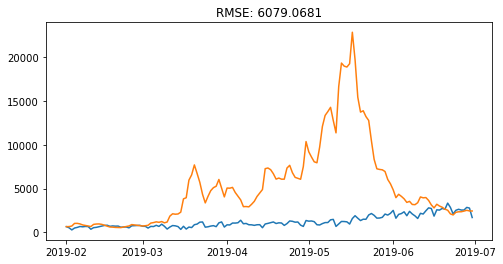

In [205]:
predictions_ARIMA_l = np.exp(predictions_ARIMA_log_l)
plt.plot(df_arima_l)
plt.plot(predictions_ARIMA_l)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_l-df_arima_l['daily_trips'])**2)/len(df_arima_l)))
print('R2: ',r2_score(predictions_ARIMA_l, df_arima_l["daily_trips"]))

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D

Text(0.5, 1.0, 'RSS: 36.9421')

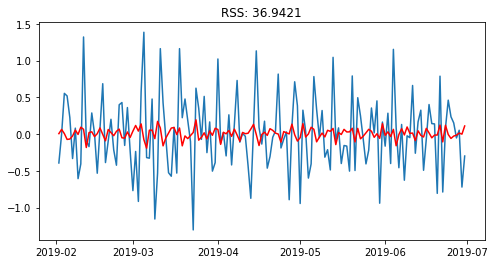

In [190]:
#AR Model Bochum
model_b = ARIMA(ts_log_b, order=(1, 1, 0))  
results_AR_b = model_b.fit(disp=-1)  
plt.plot(ts_log_b_diff)
plt.plot(results_AR_b.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_b.fittedvalues-ts_log_b_diff)**2))

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import 

Text(0.5, 1.0, 'RSS: nan')

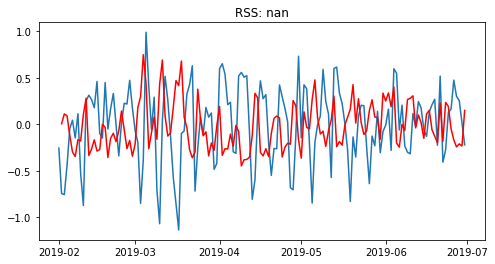

In [191]:
#MA Model Bochum
model_b = ARIMA(ts_log_b, order=(1, 1, 1))  
results_MA_b = model_b.fit(disp=-1)  
plt.plot(ts_log_b_decompose)
plt.plot(results_MA_b.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA_b.fittedvalues-ts_log_b_decompose)**2))

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import 

Text(0.5, 1.0, 'RSS: 28.5062')

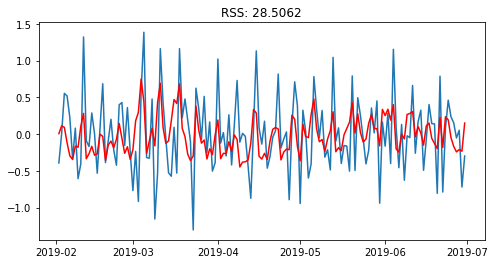

In [192]:
#ARIMA Model Bochum
model_b = ARIMA(ts_log_b, order=(1, 1, 1))  
results_ARIMA_b = model_b.fit(disp=-1)  
plt.plot(ts_log_b_diff)
plt.plot(results_ARIMA_b.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_b.fittedvalues-ts_log_b_diff)**2))

In [193]:
predictions_ARIMA_diff_b = pd.Series(results_ARIMA_b.fittedvalues, copy=True)
predictions_ARIMA_diff_b.head()

2019-02-02    0.006358
2019-02-03    0.112360
2019-02-04    0.092168
2019-02-05   -0.118563
2019-02-06   -0.296586
dtype: float64

In [194]:
predictions_ARIMA_diff_cumsum_b = predictions_ARIMA_diff_b.cumsum()
predictions_ARIMA_diff_cumsum_b.head()

2019-02-02    0.006358
2019-02-03    0.118717
2019-02-04    0.210886
2019-02-05    0.092322
2019-02-06   -0.204264
dtype: float64

In [195]:
predictions_ARIMA_log_b = pd.Series(ts_log_b.iloc[0], index=ts_log_b.index)
predictions_ARIMA_log_b = predictions_ARIMA_log_b.add(predictions_ARIMA_diff_cumsum_b,fill_value=0)
predictions_ARIMA_log_b.head()

2019-02-01    3.688879
2019-02-02    3.695237
2019-02-03    3.807597
2019-02-04    3.899765
2019-02-05    3.781202
dtype: float64

R2:  -87.55143942284256


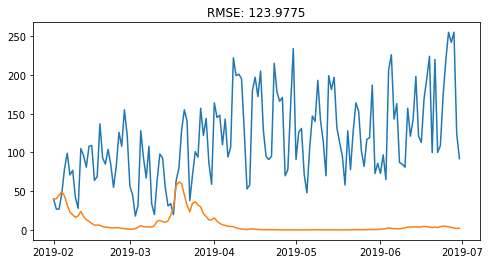

In [196]:
predictions_ARIMA_b = np.exp(predictions_ARIMA_log_b)
plt.plot(df_arima_b)
plt.plot(predictions_ARIMA_b)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_b-df_arima_b['daily_trips'])**2)/len(df_arima_b)))
print('R2: ',r2_score(predictions_ARIMA_b, df_arima_b["daily_trips"]))

After using ARIMA we see that the predictions aren't  persuasive. 
In the following, we use SARIMA (Seasonal ARIMA Model) for both cities with the same p and q value.

In [208]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


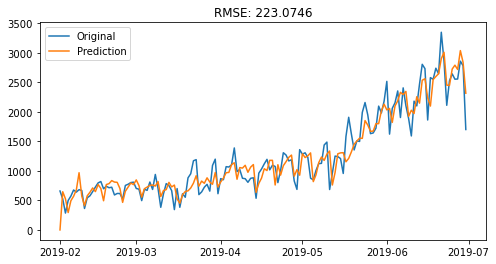

R2:  0.8923064925378332


In [209]:
#SARIMA Leipzig
y = df_arima_l[["daily_trips"]]
model = SARIMAX(y[:150], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), freq='D').fit()
# print(model.summary())
y_pred = model.predict(start='2019-02-01', end='2019-06-30',freq='D')
plt.plot(y)
plt.plot(y_pred)
plt.legend(['Original', 'Prediction'])
plt.title('RMSE: %.4f'% np.sqrt(sum((y_pred-df_arima_l['daily_trips'])**2)/len(df_arima_l)))
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('R2: ',r2_score(y_pred, df_arima_l["daily_trips"]))

C:\Users\Install\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Install\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


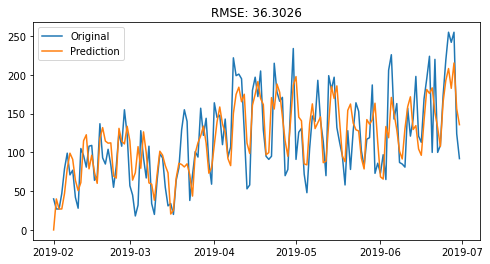

R2:  0.30730238403196475


In [210]:
#SARIMA Bochum
y_b = df_arima_b[["daily_trips"]]
model_b = SARIMAX(y_b[:150], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), freq='D').fit()
#print(model.summary())
y_pred_b = model_b.predict(start='2019-02-01', end='2019-06-30',freq='D')
plt.plot(y_b)
plt.plot(y_pred_b)
plt.legend(['Original', 'Prediction'])
plt.title('RMSE: %.4f'% np.sqrt(sum((y_pred_b-df_arima_b['daily_trips'])**2)/len(df_arima_b)))
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('R2: ',r2_score(y_pred_b, df_arima_b["daily_trips"]))

With the SARIMA model we can see two convincing prediction plots for Leipzig and Bochum. The R2 is quite well for Leipzig, unfortunately not for Bochum.